<a href="https://colab.research.google.com/github/vlongle/Neurosimulation/blob/master/ConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [0]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics.regression import mean_absolute_error as mae
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device) # expect device to be "device: cuda:0"

device: cuda:0


## Hyper-parameters

In [0]:
tets_size = 0.01 # what percentage of data is used for testing
batch_size = 200

num_epochs = 500
learning_rate = 1e-3

SEED = 1 # for train_test_split

## Data Loading / Visualization

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [0]:
root_path = "/content/drive/My Drive/summer2019/REU/Time Series/"
data_filename = "varyHitI_uniform_2000.txt"
data = np.loadtxt(root_path + data_filename)

In [0]:
'''
X: each element X[i] is array of len 400, where X[i][t] represents the 
number of spikes in the interval t. 

y: Parameters HitI (rate of exp r.v in Poisson process). We change it to the
mean delay time by doing 1000/y.
'''
y = data[:, 0].reshape(-1, 1)
X = data[:, 1:]

y = 1000/y

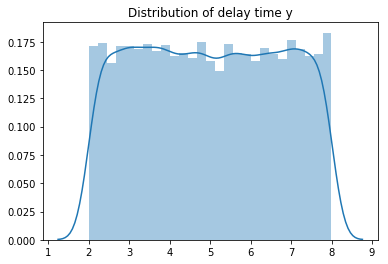

In [7]:
plt.title("Distribution of delay time y")
sns.distplot(y) # expect this to be uniform on 2-8 ms.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=SEED)


dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
train_loader = DataLoader(dataset, batch_size=batch_size)

print('Test size:', y_test.shape[0])
print('Train size:', len(train_loader)*batch_size)

Test size: 200
Train size: 19800


In [9]:
print(y_train[0:10])
print(y_test[0:10])

# pattern for y_test should be 5.89911336, 2.28588671, 7.96838146

[[7.98881566]
 [7.59145809]
 [2.77248695]
 [5.06559951]
 [3.11037153]
 [3.518426  ]
 [5.69485811]
 [5.66007834]
 [5.4887152 ]
 [7.21860089]]
[[5.89911336]
 [2.28588671]
 [7.96838146]
 [5.19715404]
 [3.55053116]
 [3.59942697]
 [5.43357187]
 [2.91892397]
 [3.72202433]
 [7.9591853 ]]


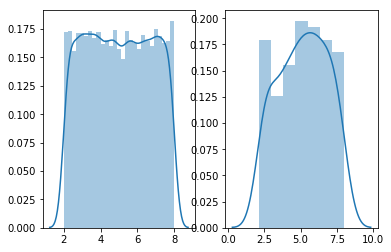

In [10]:
plt.title("y_train vs y_test distribution")

plt.rcParams["figure.figsize"] = (20,10)

plt.subplot(1, 2, 1)
sns.distplot(y_train)
plt.subplot(1, 2, 2)
sns.distplot(y_test)

## Model Architecture: Convolution

In [0]:
# 3 layers ConvNet
class ConvNet1Layer(nn.Module):
    def __init__(self):
        super(ConvNet1Layer, self).__init__()
        # (N, 1, 400)
        self.convLayer1 = nn.Sequential(
                nn.Conv1d(1, 20, kernel_size=21), # in_channels = 1
               nn.BatchNorm1d(num_features=20),
              nn.ReLU(),
            nn.MaxPool1d(kernel_size=10)) 
        # after conv1d = (N, 150, 390)
        # after maxPool = (N, 150, 78)

        
        self.fc1 = nn.Linear(760,2048)
        self.fc2 = nn.Linear(2048,4096)
        self.fc3 = nn.Linear(4096,4096)
        self.out = nn.Linear(4096, 1)
        
        
       
    def forward(self, x):
        # expand 2d to 3d dimension with format (N, C_in, L)
        x = x.unsqueeze(-1) # expand out the 1d dimension. Now we have (N, L, 1)
        x = x.permute(0, 2, 1) # swap dimensions to (N, 1, L)
        
        # Convolution layers
        x = self.convLayer1(x)


        x = x.reshape(x.size(0), -1) # x.size(0) = batch_size. This flattens 

        
        # Deep ANN
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))

        x = self.out(x)
        return x

In [0]:
# 3 layers ConvNet
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # (N, 1, 400)
        self.convLayer1 = nn.Sequential(
                nn.Conv1d(1, 150, kernel_size=11), # in_channels = 1
               nn.BatchNorm1d(num_features=150),
              nn.ReLU(),
            nn.MaxPool1d(kernel_size=5)) 
        # after conv1d = (N, 150, 390)
        # after maxPool = (N, 150, 78)

        self.convLayer2 = nn.Sequential(
          nn.Conv1d(150, 250, kernel_size=11),
           nn.BatchNorm1d(num_features=250),
           nn.ReLU(),
           nn.MaxPool1d(kernel_size=4))
        # after Conv1d out = (N, 250, 68)
        # after MaxPool = (N, 250, 17)
      
        self.convLayer3 = nn.Sequential(
           nn.Conv1d(250, 500, kernel_size=8),
            nn.BatchNorm1d(num_features=500),
           nn.ReLU(),
           nn.MaxPool1d(kernel_size=5))      
        # after conv1d = (N, 500, 10)
        # after MaxPool = (N, 500, 2)

        self.fc1 = nn.Linear(1000,2048)
        self.fc2 = nn.Linear(2048,4096)
        self.fc3 = nn.Linear(4096,4096)
        self.out = nn.Linear(4096, 1)
        
        
       
    def forward(self, x):
        # expand 2d to 3d dimension with format (N, C_in, L)
        x = x.unsqueeze(-1) # expand out the 1d dimension. Now we have (N, L, 1)
        x = x.permute(0, 2, 1) # swap dimensions to (N, 1, L)
        
        # Convolution layers
        x = self.convLayer1(x)
        x = self.convLayer2(x)
        x = self.convLayer3(x)

        x = x.reshape(x.size(0), -1) # x.size(0) = batch_size. This flattens 

        
        # Deep ANN
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))

        x = self.out(x)
        return x

In [0]:
# 3 layers ConvNet
class ConvNet4Layers(nn.Module):
    def __init__(self):
        super(ConvNet4Layers, self).__init__()
        # (N, 1, 400)
        self.convLayer1 = nn.Sequential(
                nn.Conv1d(1, 150, kernel_size=21), # in_channels = 1
               nn.BatchNorm1d(num_features=150),
              nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)) 
        # after conv1d = (N, 150, 380)
        # after maxPool = (N, 150, 190)

        self.convLayer2 = nn.Sequential(
          nn.Conv1d(150, 250, kernel_size=11),
           nn.BatchNorm1d(num_features=250),
           nn.ReLU(),
           nn.MaxPool1d(kernel_size=4))
        # after Conv1d out = (N, 250, 180)
        # after MaxPool = (N, 250, 45)
      
        self.convLayer3 = nn.Sequential(
           nn.Conv1d(250, 500, kernel_size=16),
            nn.BatchNorm1d(num_features=500),
           nn.ReLU(),
           nn.MaxPool1d(kernel_size=3))      
        # after conv1d = (N, 500, 30)
        # after MaxPool = (N, 500, 10)
        
        self.convLayer4 = nn.Sequential(
           nn.Conv1d(500, 1000, kernel_size=7),
            nn.BatchNorm1d(num_features=1000),
           nn.ReLU(),
           nn.MaxPool1d(kernel_size=2))    
        # after conv1d = (N, 4, 10)
        # after MaxPool1d(N, 2 ,500)
          
          
        self.fc1 = nn.Linear(2000,4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,4096)
        self.out = nn.Linear(4096, 1)
        
        
       
    def forward(self, x):
        # expand 2d to 3d dimension with format (N, C_in, L)
        x = x.unsqueeze(-1) # expand out the 1d dimension. Now we have (N, L, 1)
        x = x.permute(0, 2, 1) # swap dimensions to (N, 1, L)
        
        # Convolution layers
        x = self.convLayer1(x)
        x = self.convLayer2(x)
        x = self.convLayer3(x)
        x = self.convLayer4(x)


        x = x.reshape(x.size(0), -1) # x.size(0) = batch_size. This flattens 

        
        # Deep ANN
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))

        x = self.out(x)
        return x

## Model Architecture: DNN

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(400,2048)
        self.fc2 = nn.Linear(2048,2048)
        self.fc3 = nn.Linear(2048,2048)

        self.out = nn.Linear(2048, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))

        x = self.out(x)
        return x

class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()

        self.fc1 = nn.Linear(400,1028)
        self.fc2 = nn.Linear(1028,2048)
        self.out = nn.Linear(2048, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)
        return x

## Training / Testing Loop

In [0]:
def test(net, X_test, y_test, ret_pred=False):
  with torch.no_grad():
    net.eval()
    if not torch.is_tensor(X_test):
      X_test = torch.FloatTensor(X_test).to(device)
    y_pred = net(X_test).cpu().numpy()
    cur_mae = mae(y_pred, y_test)
  if ret_pred:
    return cur_mae, y_pred
  return cur_mae

In [0]:
def train(net, optimizer, train_loader, X_test, y_test, num_epochs=200,\
          scheduler=None):
    
    has_scheduler = bool(scheduler)
    print('Has_scheduler', has_scheduler)
    # L1 loss i.e MAE
    criterion = nn.L1Loss()

    losses = []
    maes = []

    for epoch in range(num_epochs):
        net.train()
        for i_batch, data in enumerate(train_loader, 0):
            X, Y = data
            X = X.to(device)
            Y = Y.to(device)

            optimizer.zero_grad()
            out = net(X)

            loss = criterion(out, Y)
            loss.backward()
            optimizer.step()
        

              
        if (epoch+1) % 1 == 0:
          cur_mae = test(net, X_test, y_test)
          print('Epoch %d | test %f | train %f' % (epoch+1, cur_mae, loss.item()))
          maes.append(cur_mae)
          if has_scheduler:
            scheduler.step(cur_mae)
            
        losses.append(loss.item())

    return (losses, maes)


In [0]:
def start_training(model_type):
  if model_type == "3 layers convnet":
    net = ConvNet()
  elif model_type == "1 layer convnet":
    net = ConvNet1Layer()
  elif model_type == "4 layers convnet":
    net = ConvNet4Layers()
  elif model_type == "Big DNN":
    net = Net()
  elif model_type == "Small DNN":
    net = SmallNet()
  else:
    raise Exception("Must pick valid model: 3 layers convnet,1 layer convnet, \
                    Big DNN, Small DNN")
    
  # https://pytorch.org/docs/stable/optim.html
  # Reduce learning rate when a metric has stopped improving.

  print("Net architecture \n", net)
  net.to(device)
  
  print("\n ==== TRAINING === \n")
  
  # https://pytorch.org/docs/stable/optim.html
  # Reduce learning rate when a metric has stopped improving.
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',\
                                verbose=True, patience=20, factor=0.8)
  losses, maes = train(net, optimizer, train_loader, X_test,\
                       y_test, num_epochs=num_epochs, scheduler=scheduler)
  
  
  return net, losses, maes


In [0]:
def post_train_analysis(net, losses, maes):
  plt.plot(range(len(losses)), losses, label='train')
  
  print('best mae:', np.min(maes), 'at', np.argmin(maes))

  plt.title("Train / Test MAES")
  plt.plot(range(len(maes)), maes, label='test')
  plt.legend(prop={'size': 20})
  plt.show()

  
  final_mae, y_pred = test(net, X_test, y_test, ret_pred=True)
  
  print('y_pred size | ', y_pred.shape)
  print(y_pred[0:10])
  print('y_test\n', y_test[0:10])
  
  
  error = np.absolute((y_pred - y_test).squeeze())
  sns.scatterplot(y_test.squeeze(), error)
  plt.show()

  print('final_mae', final_mae)

  plt.title('Y: actual vs predicted')
  plt.subplot(1, 2, 1)
  sns.distplot(y_test)
  plt.subplot(1, 2, 2)
  sns.distplot(y_pred)


  plt.show()

  

##  Result: Convolution

In [19]:
conv_net_4, losses_4, maes_4 = start_training("4 layers convnet")

Net architecture 
 ConvNet4Layers(
  (convLayer1): Sequential(
    (0): Conv1d(1, 150, kernel_size=(21,), stride=(1,))
    (1): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convLayer2): Sequential(
    (0): Conv1d(150, 250, kernel_size=(11,), stride=(1,))
    (1): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (convLayer3): Sequential(
    (0): Conv1d(250, 500, kernel_size=(16,), stride=(1,))
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (convLayer4): Sequential(
    (0): Conv1d(500, 1000, kernel_size=(7,), stride=(1,))
    (1): BatchNorm1d(1000, eps=1e-05, mom

best mae: 0.17313420882370678 at 105


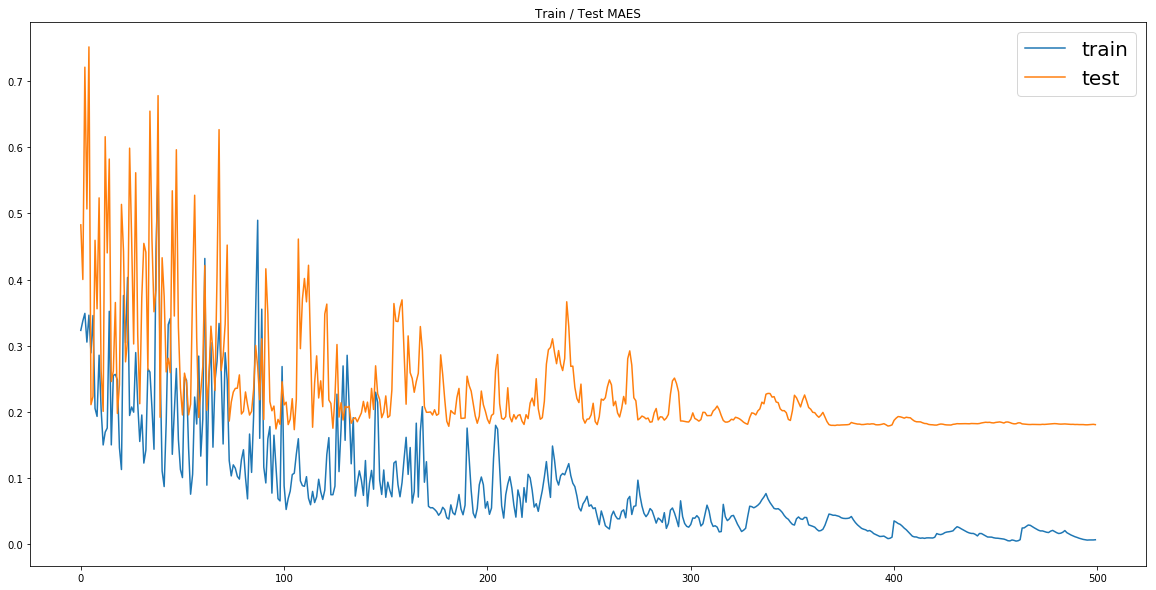

y_pred size |  (200, 1)
[[5.7653723]
 [2.2359228]
 [7.5997944]
 [5.2836814]
 [3.4872231]
 [3.41456  ]
 [5.30898  ]
 [2.8639166]
 [4.064374 ]
 [7.7269087]]
y_test
 [[5.89911336]
 [2.28588671]
 [7.96838146]
 [5.19715404]
 [3.55053116]
 [3.59942697]
 [5.43357187]
 [2.91892397]
 [3.72202433]
 [7.9591853 ]]


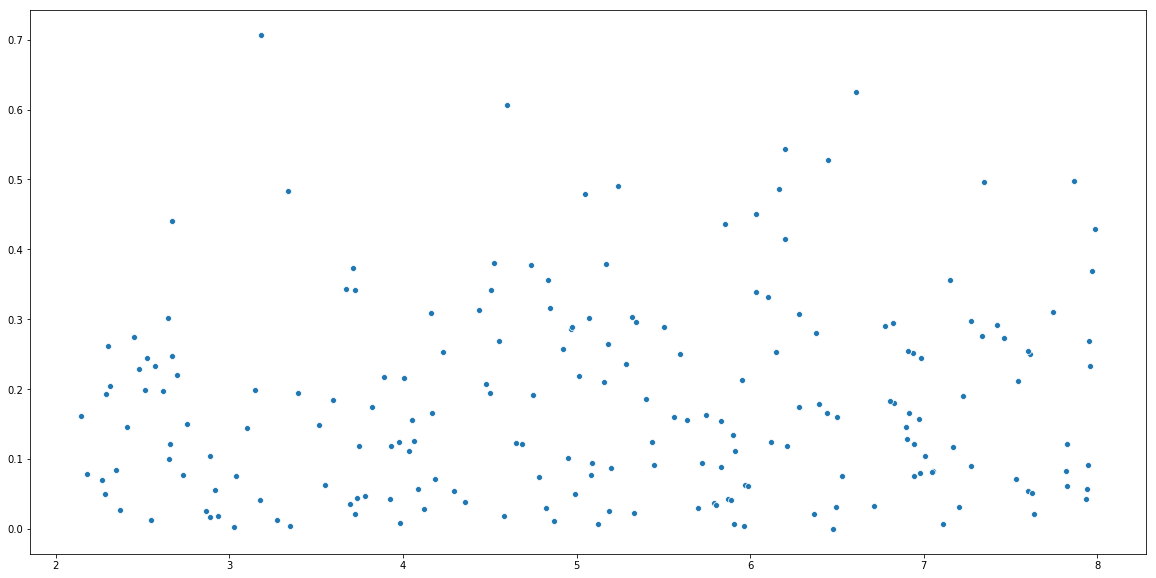

final_mae 0.1807715751764194


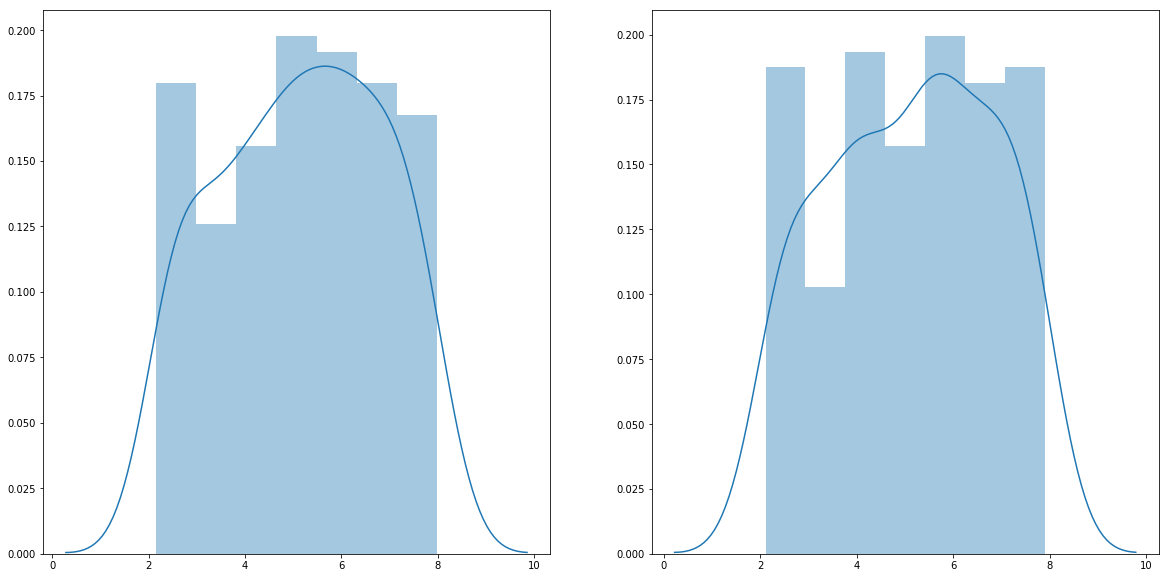

In [20]:
post_train_analysis(conv_net_4, losses_4, maes_4)

In [21]:
conv_net, losses, maes = start_training("1 layer convnet")

Net architecture 
 ConvNet1Layer(
  (convLayer1): Sequential(
    (0): Conv1d(1, 20, kernel_size=(21,), stride=(1,))
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=10, stride=10, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=760, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (out): Linear(in_features=4096, out_features=1, bias=True)
)

 ==== TRAINING === 

Has_scheduler True
Epoch 1 | test 0.586798 | train 0.464134
Epoch 2 | test 0.417739 | train 1.045928
Epoch 3 | test 0.488604 | train 0.559650
Epoch 4 | test 0.498037 | train 0.483728
Epoch 5 | test 0.503923 | train 0.456941
Epoch 6 | test 0.573268 | train 0.440867
Epoch 7 | test 0.585848 | train 0.363819
Epoch 8 | test 0.576195 | train 0.356382
Epoch 9 | test 0.467730 | train 0.360968
Epoch 10 | test 0.457999

best mae: 0.17826440271320115 at 107


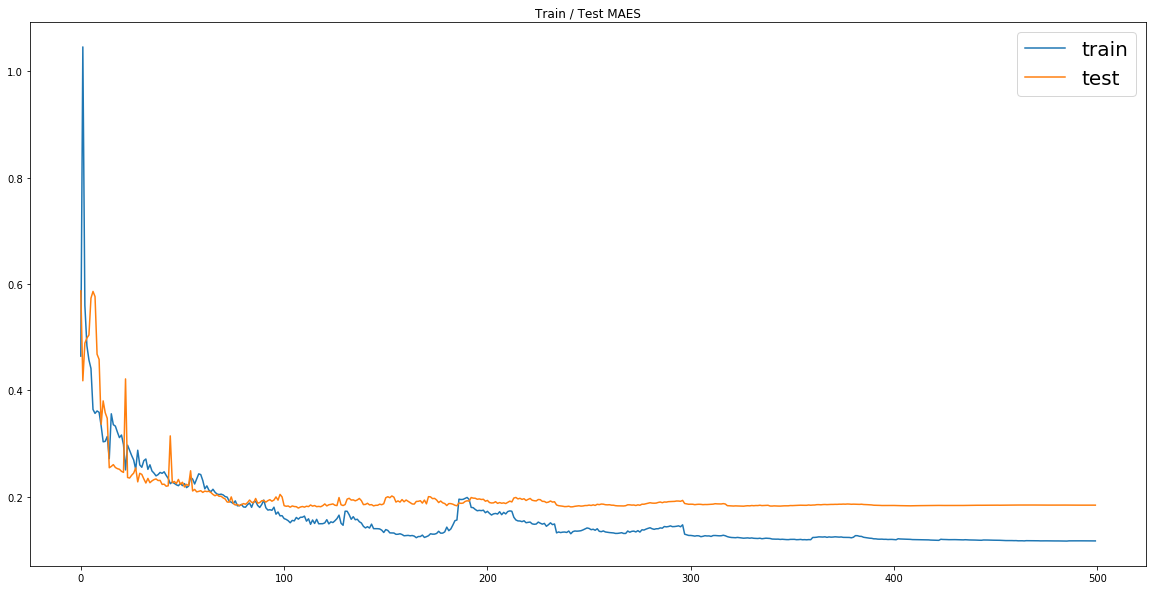

y_pred size |  (200, 1)
[[5.769285 ]
 [2.1828651]
 [7.7494574]
 [5.6231856]
 [3.6030064]
 [3.4910374]
 [5.179691 ]
 [2.868121 ]
 [3.867836 ]
 [7.900718 ]]
y_test
 [[5.89911336]
 [2.28588671]
 [7.96838146]
 [5.19715404]
 [3.55053116]
 [3.59942697]
 [5.43357187]
 [2.91892397]
 [3.72202433]
 [7.9591853 ]]


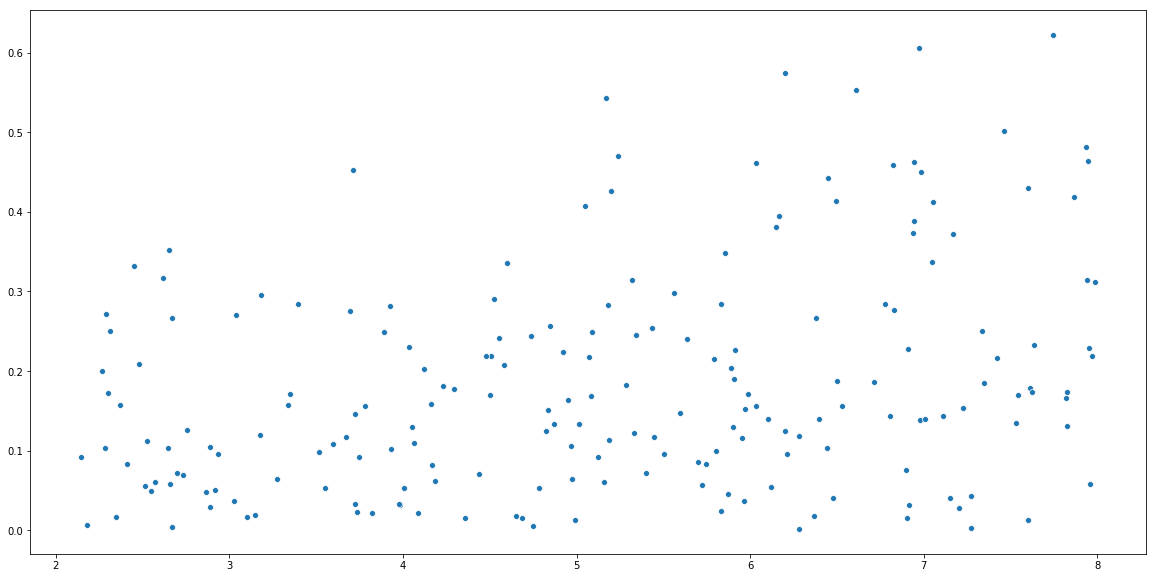

final_mae 0.1837279885276867


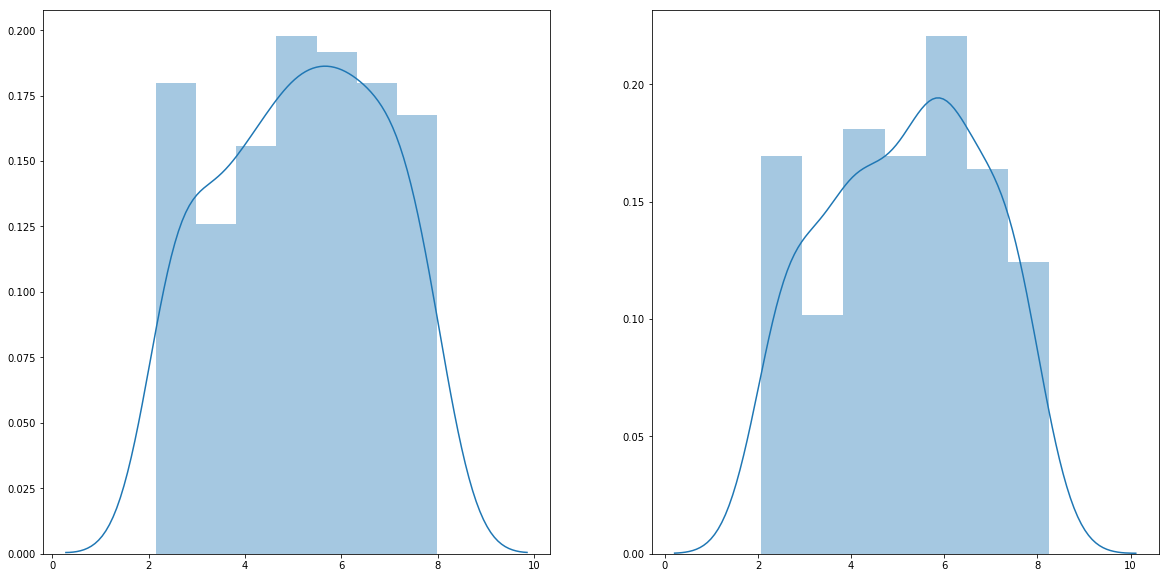

In [22]:
post_train_analysis(conv_net, losses, maes)

In [23]:
conv_net_3, losses_3, maes_3 = start_training("3 layers convnet")

Net architecture 
 ConvNet(
  (convLayer1): Sequential(
    (0): Conv1d(1, 150, kernel_size=(11,), stride=(1,))
    (1): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (convLayer2): Sequential(
    (0): Conv1d(150, 250, kernel_size=(11,), stride=(1,))
    (1): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (convLayer3): Sequential(
    (0): Conv1d(250, 500, kernel_size=(8,), stride=(1,))
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1000, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=4096, bias=True)
  (fc3)

best mae: 0.16773193299778646 at 17


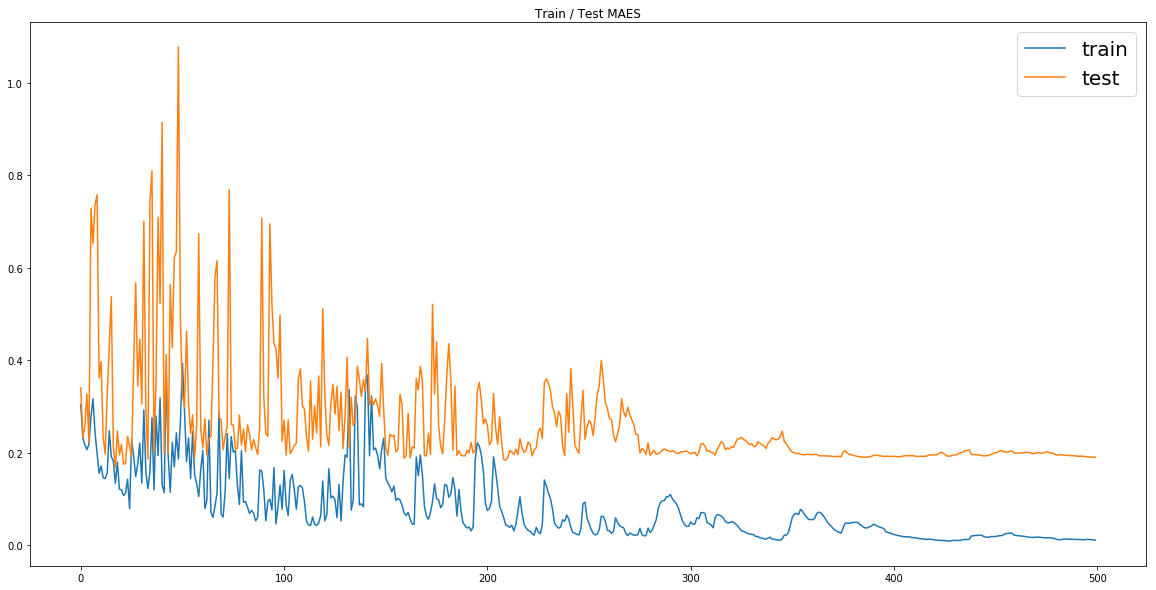

y_pred size |  (200, 1)
[[5.727154 ]
 [2.2369308]
 [7.8120403]
 [5.5202284]
 [3.6075137]
 [3.505206 ]
 [5.5114365]
 [3.008133 ]
 [3.9164596]
 [7.5956645]]
y_test
 [[5.89911336]
 [2.28588671]
 [7.96838146]
 [5.19715404]
 [3.55053116]
 [3.59942697]
 [5.43357187]
 [2.91892397]
 [3.72202433]
 [7.9591853 ]]


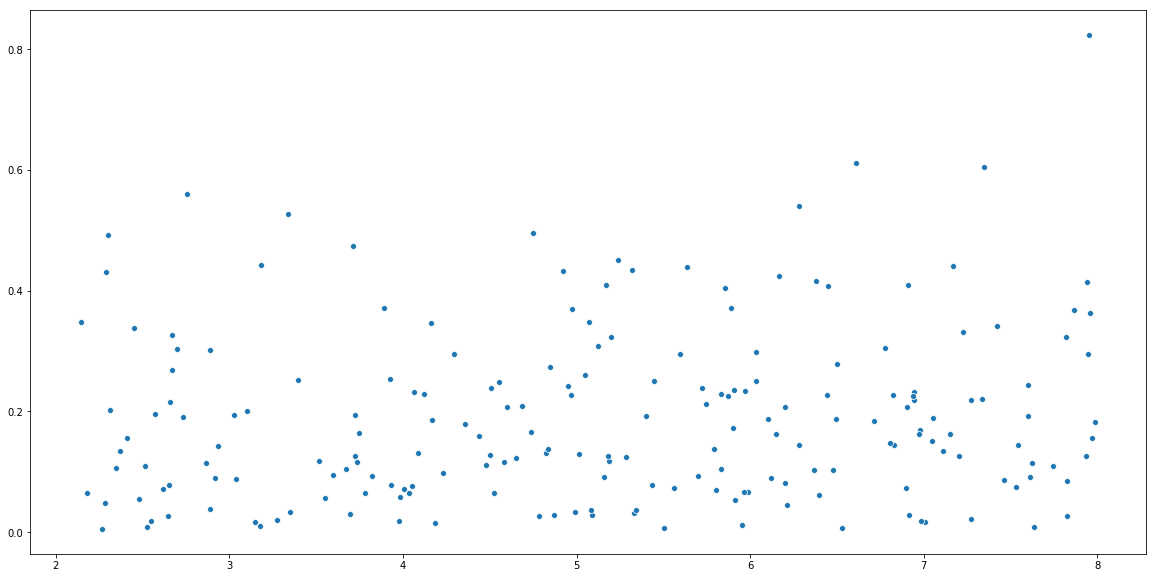

final_mae 0.19018417817931488


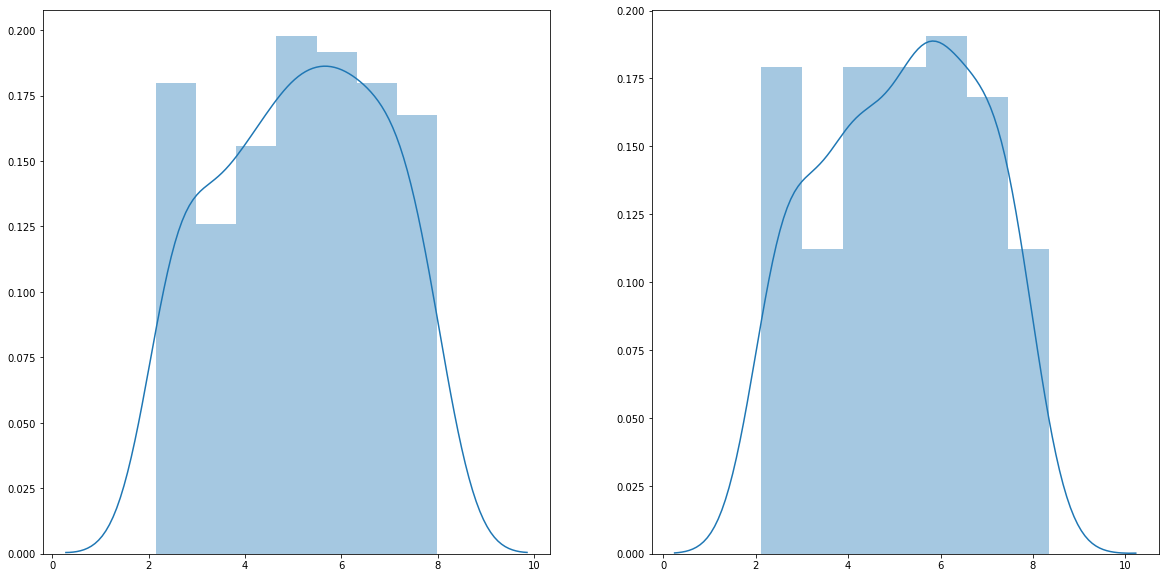

In [24]:
post_train_analysis(conv_net_3, losses_3, maes_3)

## Result: DNN

In [25]:
dnn, losses_dnn, maes_dnn = start_training("Big DNN")

Net architecture 
 Net(
  (fc1): Linear(in_features=400, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=2048, bias=True)
  (out): Linear(in_features=2048, out_features=1, bias=True)
)

 ==== TRAINING === 

Has_scheduler True
Epoch 1 | test 0.526809 | train 0.556434
Epoch 2 | test 0.420969 | train 0.502271
Epoch 3 | test 0.379639 | train 0.574739
Epoch 4 | test 0.371720 | train 0.397645
Epoch 5 | test 0.387974 | train 0.354991
Epoch 6 | test 0.412144 | train 0.595050
Epoch 7 | test 0.324179 | train 0.411012
Epoch 8 | test 0.575468 | train 0.444899
Epoch 9 | test 0.481705 | train 0.399884
Epoch 10 | test 0.410708 | train 0.446290
Epoch 11 | test 0.330711 | train 0.311354
Epoch 12 | test 0.346412 | train 0.279029
Epoch 13 | test 0.390693 | train 0.265860
Epoch 14 | test 0.402917 | train 0.514378
Epoch 15 | test 0.383926 | train 0.427777
Epoch 16 | test 0.655238 | train 0.399332
Epoch 17 | test 0.

best mae: 0.3191604875271778 at 41


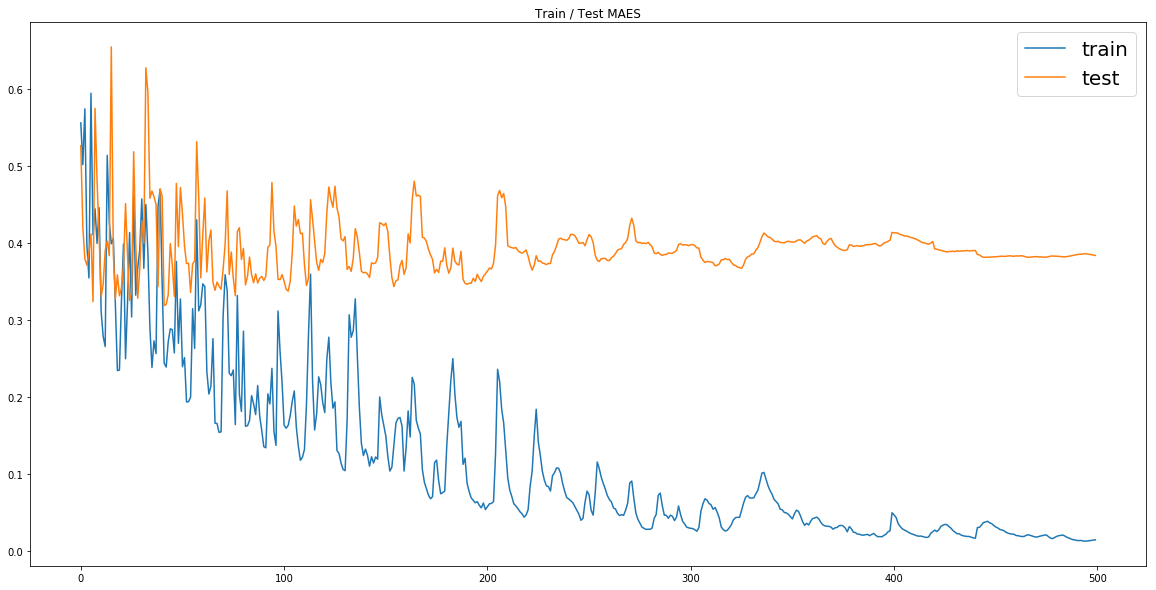

y_pred size |  (200, 1)
[[6.56959  ]
 [2.2428186]
 [6.885676 ]
 [5.2562833]
 [3.3060153]
 [4.1197248]
 [6.3299794]
 [2.983934 ]
 [4.2837033]
 [7.0968738]]
y_test
 [[5.89911336]
 [2.28588671]
 [7.96838146]
 [5.19715404]
 [3.55053116]
 [3.59942697]
 [5.43357187]
 [2.91892397]
 [3.72202433]
 [7.9591853 ]]


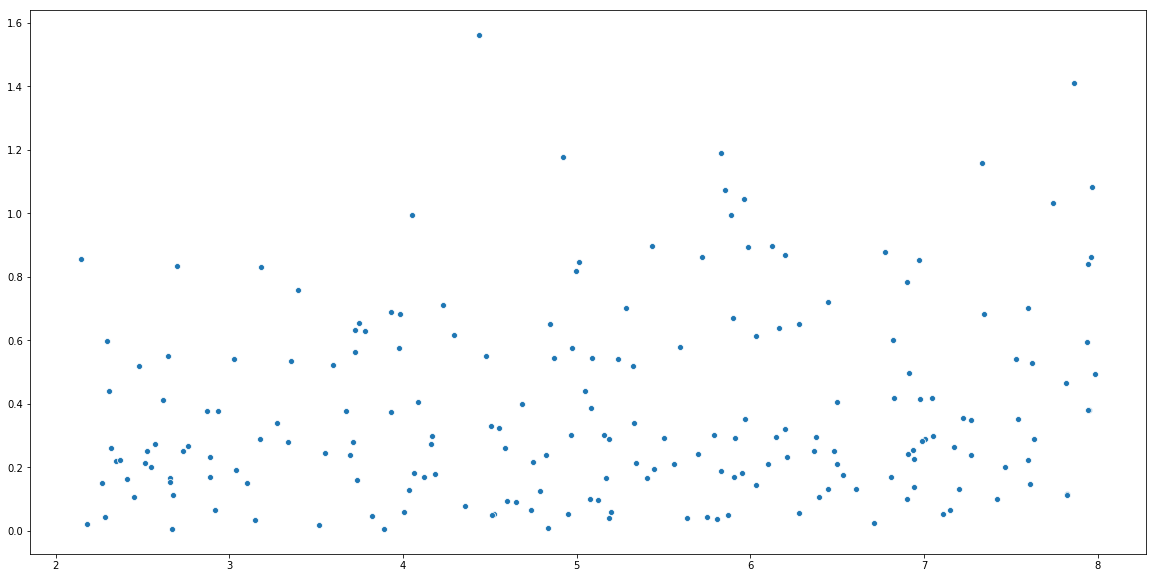

final_mae 0.3842528784069731


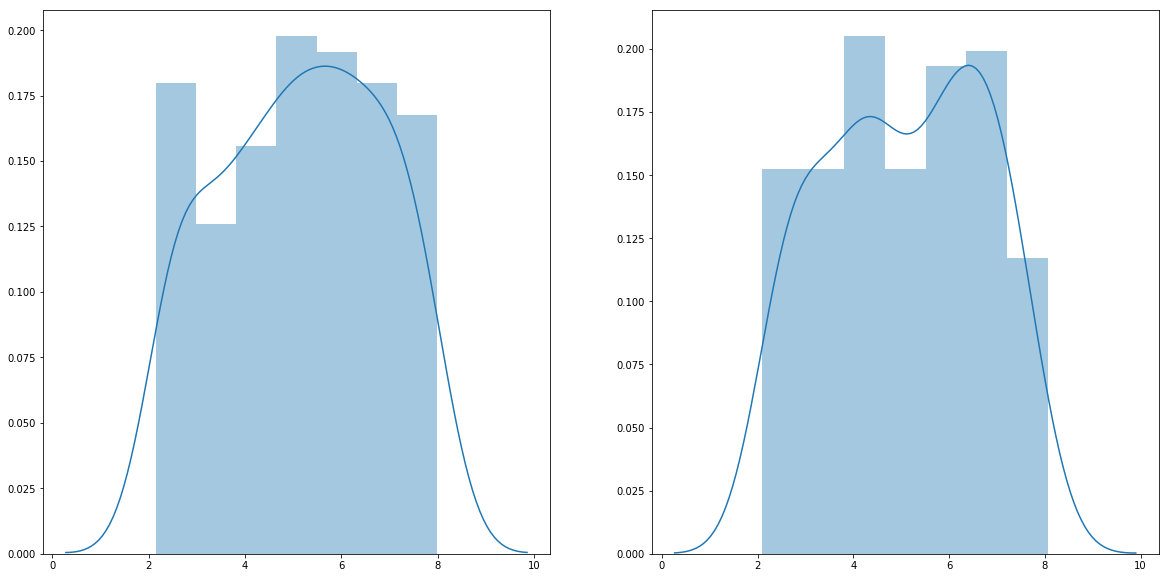

In [26]:
post_train_analysis(dnn, losses_dnn, maes_dnn)

In [27]:
small_dnn, losses_small_dnn, maes_small_dnn = start_training("Small DNN")

Net architecture 
 SmallNet(
  (fc1): Linear(in_features=400, out_features=1028, bias=True)
  (fc2): Linear(in_features=1028, out_features=2048, bias=True)
  (out): Linear(in_features=2048, out_features=1, bias=True)
)

 ==== TRAINING === 

Has_scheduler True
Epoch 1 | test 0.624132 | train 0.585808
Epoch 2 | test 0.537783 | train 0.533277
Epoch 3 | test 0.497887 | train 0.491699
Epoch 4 | test 0.484881 | train 0.416179
Epoch 5 | test 0.467114 | train 0.425499
Epoch 6 | test 0.492950 | train 0.439517
Epoch 7 | test 0.566415 | train 0.425169
Epoch 8 | test 0.475774 | train 0.405591
Epoch 9 | test 0.422389 | train 0.357946
Epoch 10 | test 0.445996 | train 0.346758
Epoch 11 | test 0.418016 | train 0.443375
Epoch 12 | test 0.418008 | train 0.373797
Epoch 13 | test 0.489862 | train 0.486578
Epoch 14 | test 0.602614 | train 0.354891
Epoch 15 | test 0.415951 | train 0.354311
Epoch 16 | test 0.436198 | train 0.411576
Epoch 17 | test 0.513113 | train 0.430656
Epoch 18 | test 0.485031 | train 0.

best mae: 0.37195317868754446 at 78


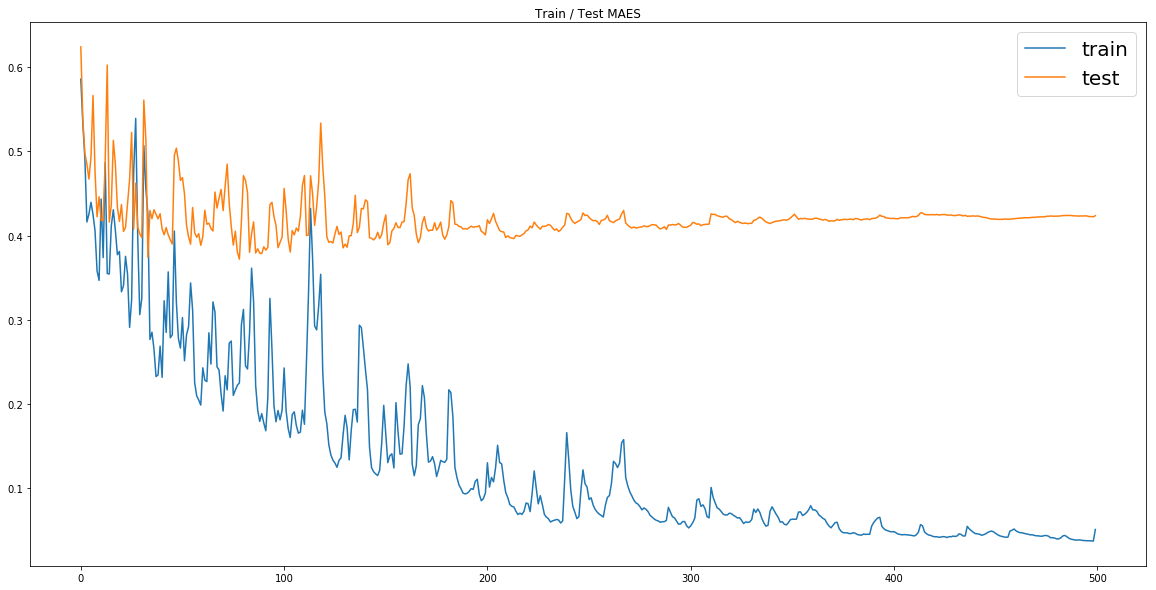

y_pred size |  (200, 1)
[[6.6910095]
 [2.2317586]
 [7.3674574]
 [5.202686 ]
 [3.3459222]
 [4.467984 ]
 [5.4189997]
 [2.9569845]
 [4.6481705]
 [7.180158 ]]
y_test
 [[5.89911336]
 [2.28588671]
 [7.96838146]
 [5.19715404]
 [3.55053116]
 [3.59942697]
 [5.43357187]
 [2.91892397]
 [3.72202433]
 [7.9591853 ]]


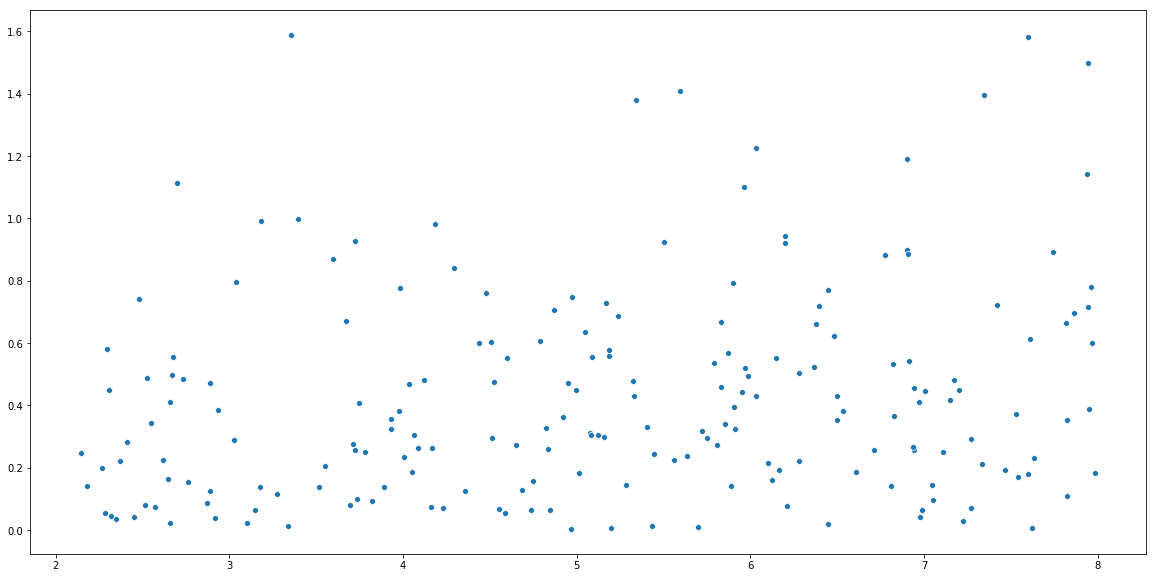

final_mae 0.42363484250652844


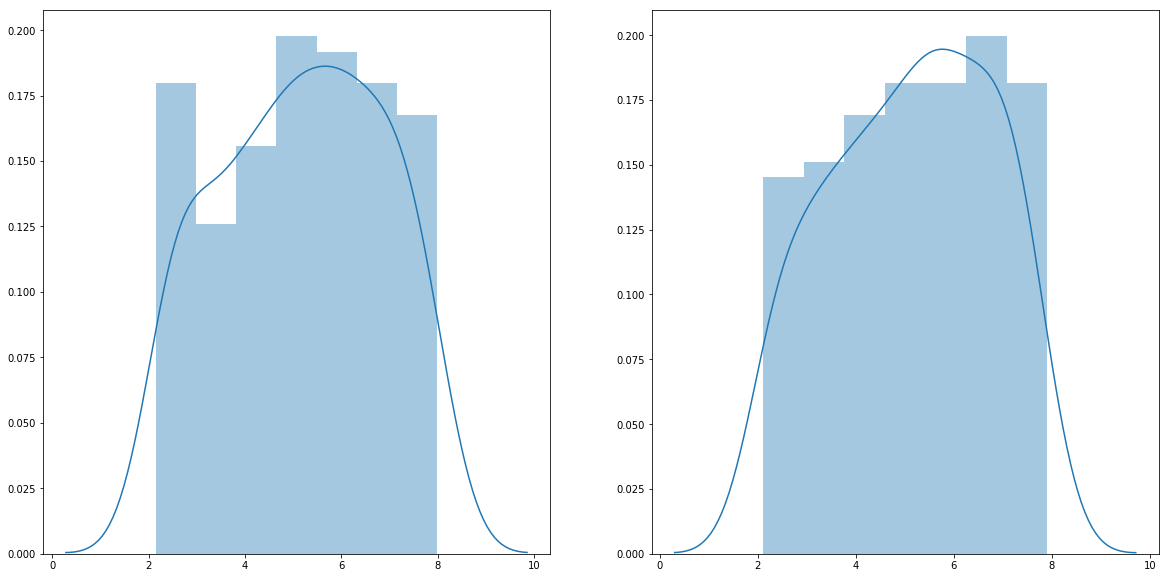

In [28]:
post_train_analysis(small_dnn, losses_small_dnn, maes_small_dnn)

## Saving Results